# Tutorial for simulated data
This tutorial provides step-by-step instructions for reproducing the simulation results presented in our paper. For each simulated dataset, we generated two modalities: one representing the transcriptome and the other representing the proteome. These datasets include multiple ground truth patterns—some shared between both modalities and others unique to a single modality. The simulated data are then used as input for our algorithm, which produces two types of outputs based on user preference.

In [1]:
# SpaMV results
import anndata
from sklearn.metrics import adjusted_rand_score

from SpaMV_copy.spamv import SpaMV
from SpaMV_copy.utils import clr_normalize_each_cell, clustering
import scanpy as sc
import matplotlib.pyplot as plt
# import wandb

for dataset in ['1_Simulation', '2_Simulation', '3_Simulation']:
    data_rna = sc.read_h5ad('Data/' + dataset + '/adata_RNA.h5ad')
    data_pro = sc.read_h5ad('Data/' + dataset + '/adata_ADT.h5ad')
    omics_names = ['Omics 1', 'Omics 2']
    sc.pp.normalize_total(data_rna)
    sc.pp.log1p(data_rna)
    sc.pp.pca(data_rna, n_comps=30)
    data_rna = anndata.AnnData(data_rna.obsm['X_pca'], obs=data_rna.obs, obsm=data_rna.obsm)
    data_pro = clr_normalize_each_cell(data_pro)
    sc.pp.pca(data_pro, n_comps=30)
    data_pro = anndata.AnnData(data_pro.obsm['X_pca'], obs=data_pro.obs, obsm=data_pro.obsm)

    # wandb.init(project=dataset)
    # wandb.login()
    # model = SpaMV([data_rna, data_pro], interpretable=False, omics_names=omics_names, max_epochs=400)
    # model.train(dataset)
    # wandb.finish()

    model = SpaMV([data_rna, data_pro], interpretable=False, omics_names=omics_names, max_epochs_stage1=10)
    model.train()

    data_rna.obsm['SpaMV'] = model.get_embedding()
    # data_rna = clustering(data_rna, n_clusters=10, key='SpaMV' ,use_pca=True)
    clustering(data_rna, n_clusters=10, key='SpaMV' ,use_pca=True)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # 1 row, 2 columns

    sc.pp.neighbors(data_rna, use_rep='SpaMV')
    sc.tl.umap(data_rna)
    sc.pl.umap(data_rna, color='SpaMV', ax=axes[0], show=False, legend_loc='none', s=20, title='UMAP')
    sc.pl.embedding(data_rna, color='SpaMV', basis='spatial', s=200, show=False, title='SpaMV on {}\nARI: {:.3f}'.format(dataset, adjusted_rand_score(data_rna.obs['cluster'], data_rna.obs['SpaMV'])), ax=axes[1])
    plt.tight_layout()
    plt.show()

/opt/anaconda3/envs/SpaMV/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/SpaMV/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/anaconda3/envs/SpaMV/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, ge

cpu


Epoch Loss:327.638: 100%|██████████| 10/10 [00:00<00:00, 11.90it/s]
/opt/anaconda3/envs/SpaMV/lib/python3.12/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "XPC_SERVICE_NAME" redefined by R and overriding existing variable. Current: "application.com.jetbrains.pycharm.161631176.161632265", R: "0"
  warnings.warn(
/opt/anaconda3/envs/SpaMV/lib/python3.12/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "R_SESSION_TMPDIR" redefined by R and overriding existing variable. Current: "/var/folders/j4/xr7t73yj6v7flbwkpls0vwcw0000gn/T//RtmpcMd6eO", R: "/var/folders/j4/xr7t73yj6v7flbwkpls0vwcw0000gn/T//RtmpMLMj59"
  warnings.warn(
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.
  


NameError: name 'rpy2' is not defined

# Interpretable dimension reduction

/opt/anaconda3/envs/SpaMV/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/SpaMV/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/anaconda3/envs/SpaMV/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, ge

dataset: 1_Simulation
cpu


Epoch Loss:1942.972: 100%|██████████| 200/200 [01:40<00:00,  1.98it/s]


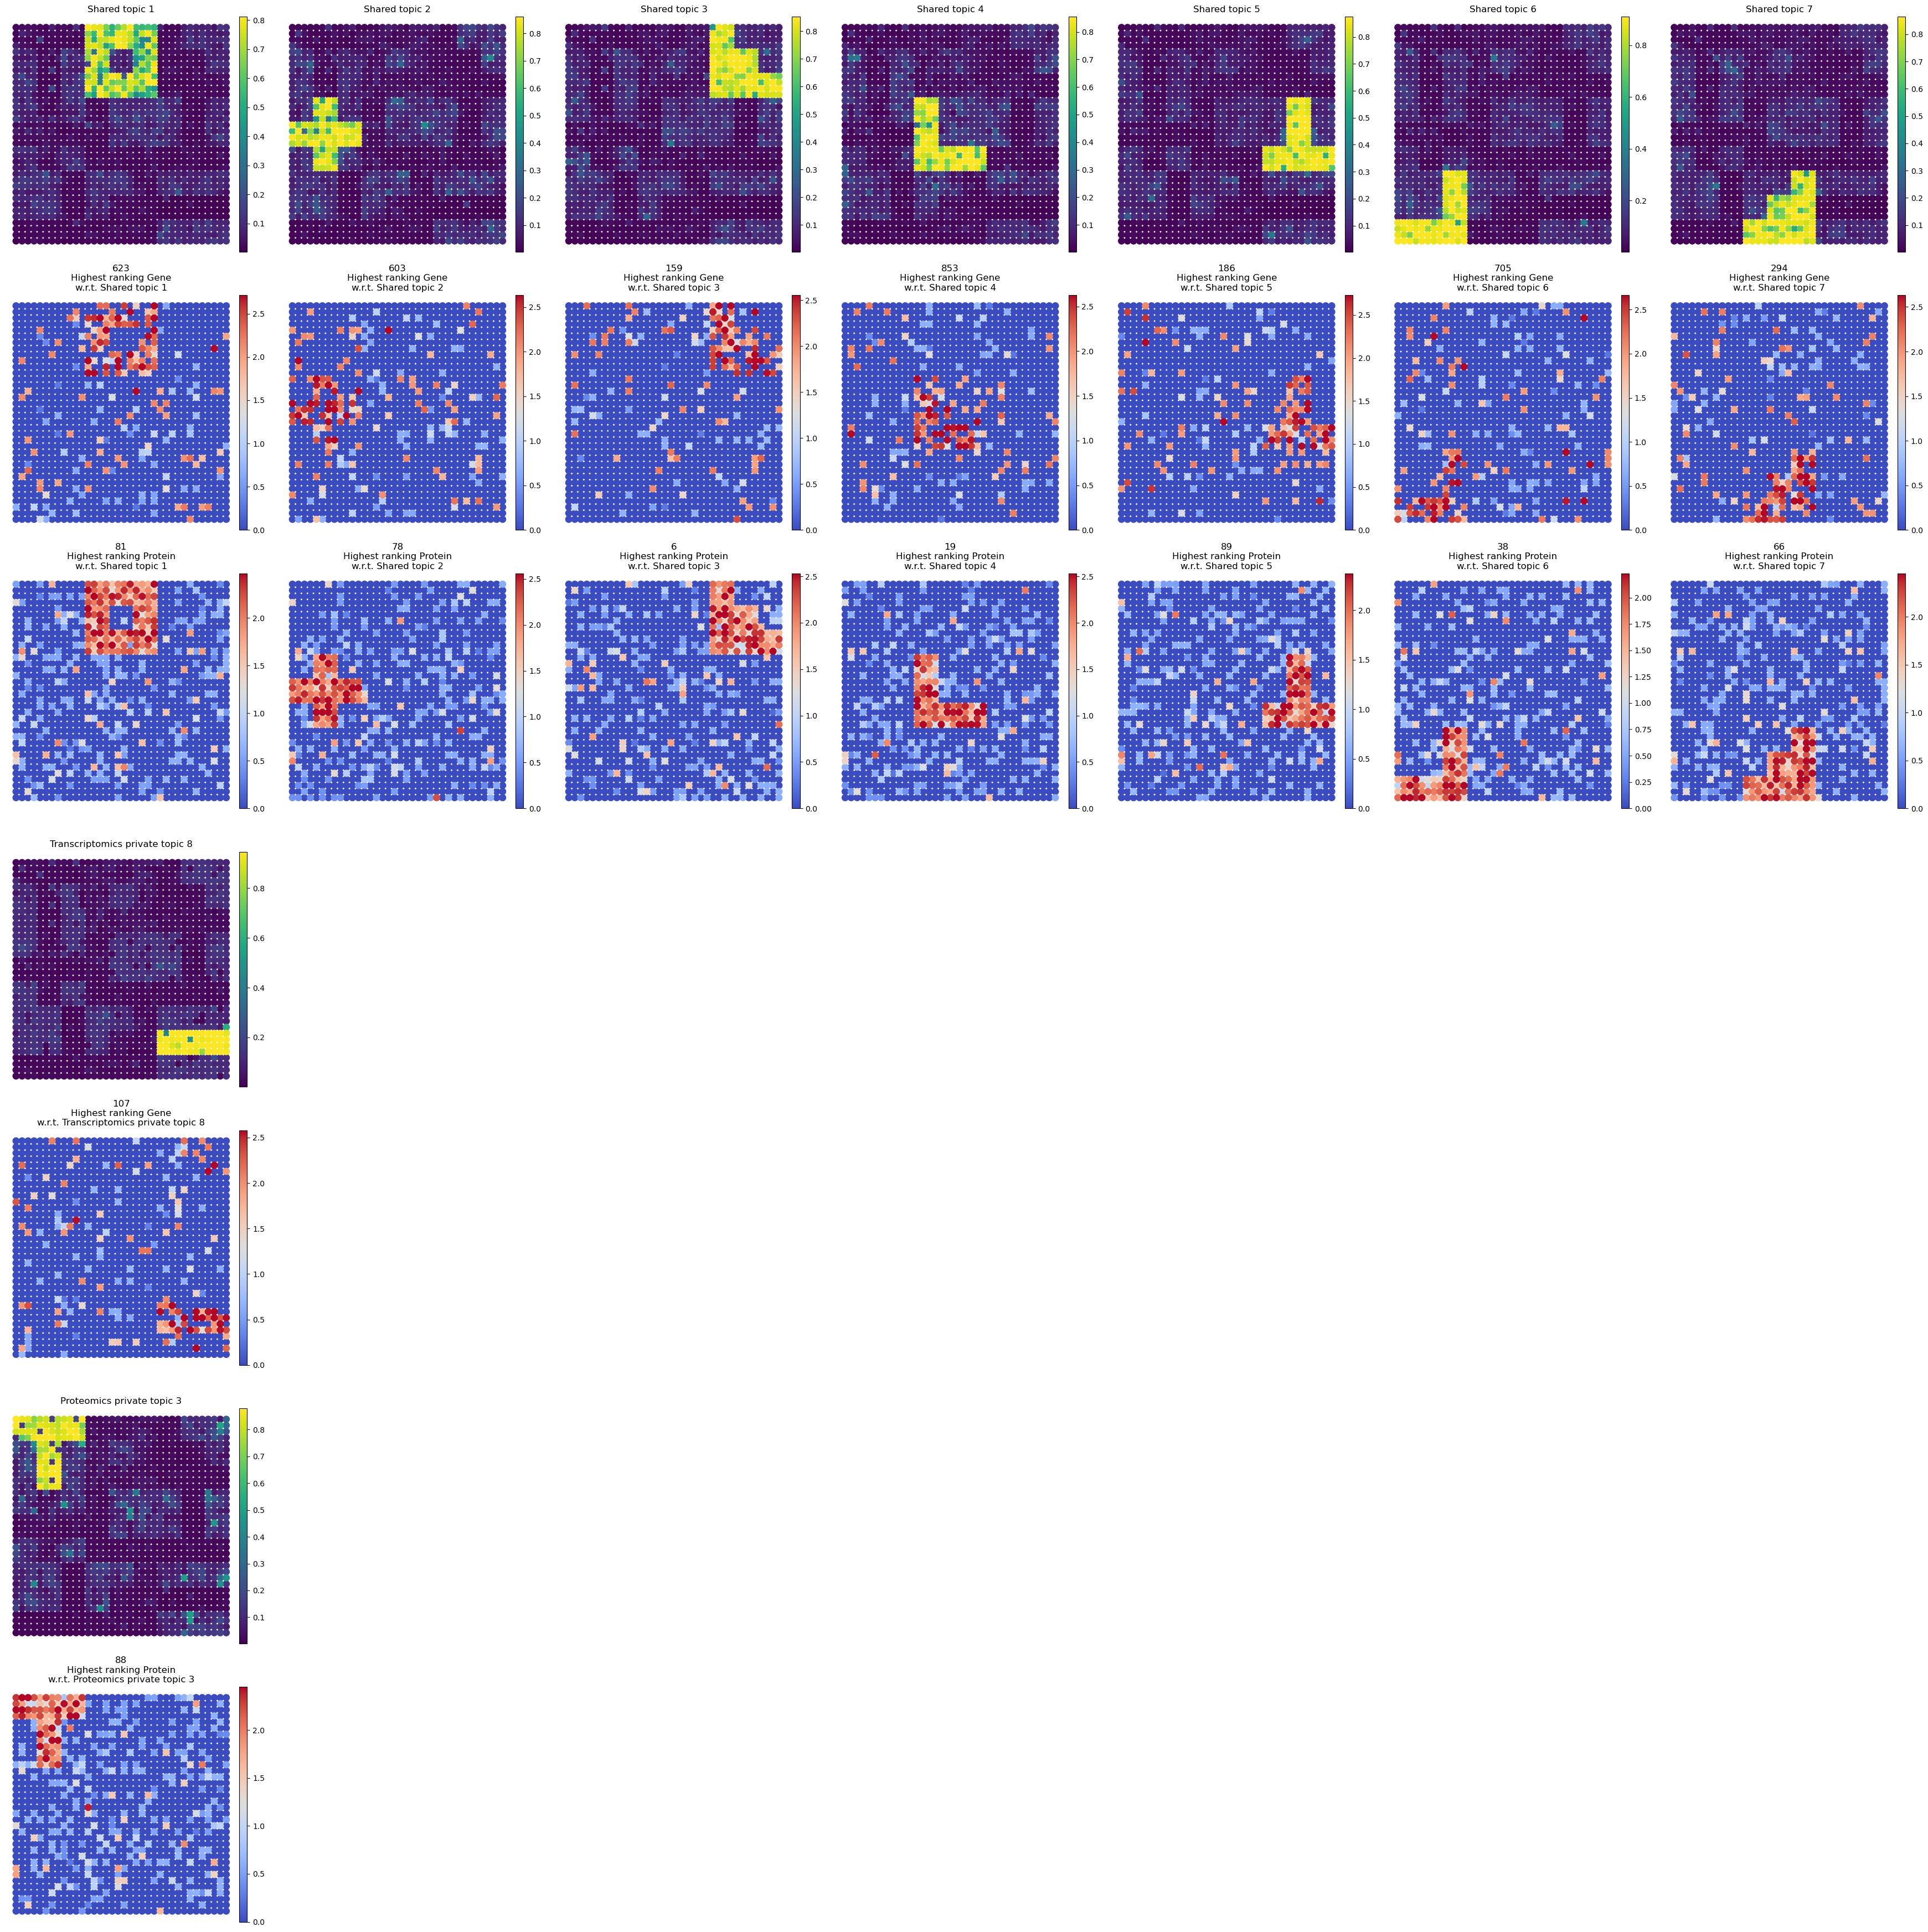

dataset: 2_Simulation
cpu


Epoch Loss:2054.239:  40%|████      | 160/400 [00:35<00:50,  4.72it/s]

In [ ]:
from SpaMV_copy.spamv import SpaMV
from SpaMV_copy.utils import clr_normalize_each_cell, plot_embedding_results
import scanpy as sc

omics_names = ['Transcriptomics', 'Proteomics']
for dataset in ['1_Simulation', '2_Simulation', '3_Simulation']:
    # for dataset in ['3_Simulation_o']:
    print('dataset:', dataset)
    data_rna = sc.read_h5ad('Data/' + dataset + '/adata_RNA.h5ad')
    sc.pp.normalize_total(data_rna)
    sc.pp.log1p(data_rna)
    data_pro = sc.read_h5ad('Data/' + dataset + '/adata_ADT.h5ad')
    data_pro = clr_normalize_each_cell(data_pro)

    model = SpaMV([data_rna, data_pro], zs_dim=10, zp_dims=[10, 10], betas=[3, 3], interpretable=True, omics_names=omics_names, threshold_background=5, max_epochs_stage1=400, max_epochs_stage2=200)
    model.train()

    z, w = model.get_embedding_and_feature_by_topic(threshold=.1)
    plot_embedding_results([data_rna, data_pro], omics_names, z, w, save=False, show=True, size=350)